Found 6146 images belonging to 9 classes.
Found 1538 images belonging to 9 classes.
🧊 Step 1: Warm-up (frozen)
Epoch 1/3
193/193 [==============================] - 174s 872ms/step - loss: 2.0997 - accuracy: 0.3101 - val_loss: 1.5900 - val_accuracy: 0.4272
Epoch 2/3
193/193 [==============================] - 160s 829ms/step - loss: 1.5108 - accuracy: 0.4780 - val_loss: 1.4011 - val_accuracy: 0.4889
Epoch 3/3
193/193 [==============================] - 165s 855ms/step - loss: 1.3433 - accuracy: 0.5187 - val_loss: 1.3322 - val_accuracy: 0.5072
🔥 Step 2: Full fine-tuning (all layers)
Epoch 1/30
193/193 [==============================] - 346s 2s/step - loss: 1.8210 - accuracy: 0.4034 - val_loss: 1.4684 - val_accuracy: 0.5013 - lr: 1.0000e-05
Epoch 2/30
193/193 [==============================] - 327s 2s/step - loss: 1.5854 - accuracy: 0.4587 - val_loss: 1.5145 - val_accuracy: 0.4974 - lr: 1.0000e-05
Epoch 3/30
193/193 [==============================] - 332s 2s/step - loss: 1.4815 - accuracy: 

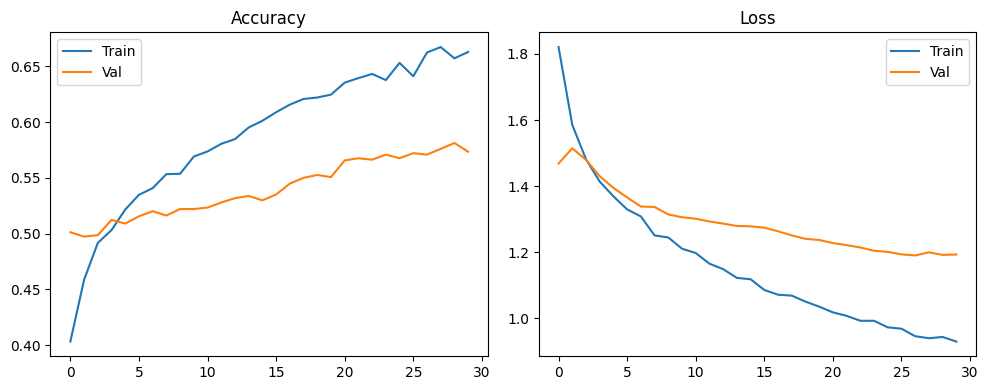

📊 Final Training Summary
📊 Best Train Accuracy: 0.6673
📊 Best Val Accuracy:   0.5813
📉 Lowest Train Loss:   0.9295
📉 Lowest Val Loss:     1.1902


In [2]:
# ========================================
# 🧠 MobileNetV2 Full Fine-Tune (Warmup + Light Aug)
# ========================================
import os, shutil, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Step 1: 깨진 이미지 제거
def clean_corrupt_images(root_dir):
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path): continue
        for fname in os.listdir(class_path):
            try:
                with Image.open(os.path.join(class_path, fname)) as img: img.verify()
            except (Image.UnidentifiedImageError, OSError):
                os.remove(os.path.join(class_path, fname))

# Step 2: 데이터 로딩
merged_root = r"C:\Users\ghwns\HJ_git\real-time-daily-activity-recognizer\merged"
train_dir, val_dir = os.path.join(merged_root, "train"), os.path.join(merged_root, "val")
clean_corrupt_images(train_dir)
clean_corrupt_images(val_dir)

IMG_SIZE, BATCH_SIZE = 224, 32
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
).flow_from_directory(train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')

# Step 3: 기본 모델 구성 (warm-up 훈련용)
def build_model(trainable=False):
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base.trainable = trainable
    if not trainable:
        for layer in base.layers: layer.trainable = False
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    out = Dense(train_gen.num_classes, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=out)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Step 4: Warm-up 훈련 (frozen)
model = build_model(trainable=False)
print("🧊 Step 1: Warm-up (frozen)")
model.fit(train_gen, validation_data=val_gen, epochs=3)

# Step 5: Unfreeze 후 재컴파일
for layer in model.layers: layer.trainable = True
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: 본 훈련 (전체 fine-tune)
print("🔥 Step 2: Full fine-tuning (all layers)")
callbacks = [
    EarlyStopping(patience=7, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.2, verbose=1),
    ModelCheckpoint("best_model_full.h5", save_best_only=True)
]
history = model.fit(train_gen, validation_data=val_gen, epochs=30, callbacks=callbacks)

# Step 7: 시각화 & 출력
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(history.history['accuracy'], label='Train'); plt.plot(history.history['val_accuracy'], label='Val'); plt.title("Accuracy"); plt.legend()
plt.subplot(1,2,2); plt.plot(history.history['loss'], label='Train'); plt.plot(history.history['val_loss'], label='Val'); plt.title("Loss"); plt.legend()
plt.tight_layout(); plt.show()

print("📊 Final Training Summary")
print(f"📊 Best Train Accuracy: {max(history.history['accuracy']):.4f}")
print(f"📊 Best Val Accuracy:   {max(history.history['val_accuracy']):.4f}")
print(f"📉 Lowest Train Loss:   {min(history.history['loss']):.4f}")
print(f"📉 Lowest Val Loss:     {min(history.history['val_loss']):.4f}")